<a href="https://colab.research.google.com/github/BioGeMT/DLforGenomics/blob/main/notebooks/One_hot_encoding_and_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network (RNN)

The idea behind RNNs is to make use of sequential information. In a traditional neural network we assume that all inputs (and outputs) are independent of each other. But for many tasks that's a bad idea. If you want to predict the next word in a sentence you better know which words came before it. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations. Another way to think about RNNs is that they have a “memory” which captures information about what has been calculated so far. Here is what a typical RNN looks like:

![](https://dennybritz.com/wp-content/uploads/2015/09/rnn.jpg)

The above diagram shows an RNN being unrolled (or unfolded) into a full network. By unrolling we simply mean that we write out the network for the complete sequence. For example, if the sequence we care about is a sentence of 5 words, the network would be unrolled into a 5-layer neural network, one layer for each word.

The formulas that govern the computation happening in a RNN are as follows:

- $x_t$ is the input at time step $t$. For example, $x_1$ could be a one-hot vector corresponding to the second word of a sentence.
- $s_t$ is the hidden state at time step $t$. It's the “memory” of the network. $s_t$ is calculated based on the previous hidden state and the input at the current step.
- $o_t$ is the output at step $t$.

There are a few things to note here:

- You can think of the hidden state $s_t$ as the memory of the network. $s_t$ captures information about what happened in all the previous time steps. The output at step $o_t$ is calculated solely based on the memory at time $t$.
- Unlike a traditional deep neural network, which uses different parameters at each layer, a RNN shares the same parameters ($U$,$V$,$W$ above) across all steps. This reflects the fact that we are performing the same task at each step, just with different inputs. This greatly reduces the total number of parameters we need to learn.
- The above diagram has outputs at each time step, but depending on the task this may not be necessary. For example, when predicting the sentiment of a sentence we may only care about the final output, not the sentiment after each word. Similarly, we may not need inputs at each time step. The main feature of an RNN is its hidden state, which captures some information about a sequence.


# Setup

## Imports

In [ ]:
from tensorflow import keras as K
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve

## Helper functions

Functions defined in previous notebook that we will use here as well.

In [ ]:
def sequence_to_ohe(
        dataset,
        sequence_size,
        channel={
            'A': 0,
            'T': 1,
            'C': 2,
            'G': 3
        }
):
    """
    fun builds the one hot encoding numpy array of each
    sample sequence.

    paramenters:
    dataset = dataset of sequences to encode
    sequence_size = can corresponds to the
    length of the input sequences
    (if all the same) or an arbitrary number can be defined.
    channel = the coding of nucleotides.

    """

    # further processing is expecting list of sequences
    if isinstance(dataset, str):
        dataset = [dataset]

    samples_size = len(dataset)
    ohe_dataset = np.zeros((samples_size, sequence_size, len(set(channel.values()))))

    for index, sequence in enumerate(dataset):
        for pos, nucleotide in enumerate(sequence):
            if nucleotide == 'N':
                continue
            ohe_dataset[index, pos, channel[nucleotide]] = 1

    return ohe_dataset

In [ ]:
def plot_ohe(seq, seq_ohe):
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    ax.imshow(seq_ohe[0, :].T, cmap='gray')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticks(range(len(seq)))
    ax.set_xticklabels(seq)
    plt.plot();

In [ ]:
def encode_dataset_ohe(df, seq_col, label_col):

    # do not forget to shuffle your data so every batch will contain both positive and negative samples
    df = df.sample(frac=1, random_state=42)
    df.reset_index(inplace=True, drop=True)

    max_length = df[seq_col].map(len).max()
    ohe_samples = sequence_to_ohe(df[seq_col], max_length)
    labels = df[label_col]

    if ohe_samples.shape[0] != labels.shape[0]:
        print('sequence and label shapes are different, something went wrong...')

    print(
        'samples',
        ohe_samples.shape,
        '\nlabels',
        labels.shape
    )

    return ohe_samples, labels

In [ ]:
def compile_model(
      model,
      learning_rate = 0.001):

    optimizer = K.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
def plot_history(history):
    """
    fun plots history of the training of the model,
    accuracy and loss of the training and validation set

    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(epochs, acc)
    axes[0].plot(epochs, val_acc)
    axes[0].set_title('Accuracy')

    axes[1].plot(epochs, loss, label='Training')
    axes[1].plot(epochs, val_loss, label='Validation')
    axes[1].set_title('Loss')

    fig.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
    fig.tight_layout()

    plt.show()

## Downloads

In [ ]:
!wget https://raw.githubusercontent.com/BioGeMT/DLforGenomics/main/data/Helwak_2013/one_miRNA/miRNA_train_set.tsv -O miRNA_train_set.tsv

--2024-05-31 13:31:16--  https://raw.githubusercontent.com/BioGeMT/DLforGenomics/main/data/Helwak_2013/one_miRNA/miRNA_train_set.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101082 (99K) [text/plain]
Saving to: ‘miRNA_train_set.tsv’

miRNA_train_set.tsv 100%[===================>]  98.71K  --.-KB/s    in 0.02s   

2024-05-31 13:31:16 (3.92 MB/s) - ‘miRNA_train_set.tsv’ saved [101082/101082]



# Data preparation

In [ ]:
df = pd.read_csv('miRNA_train_set.tsv', sep='\t')
df

,gene,label
0,AGCACTGCCGCCGGGGACTGCTCAGCAACCACACCGGCAGCCCGCG...,1
1,CTTCTCGGAGACGGTGCGCATCATCAACCGCAAGGTGAAGCCGCGG...,1
2,GGGCTGGGCAAAGAATGTGCAAAAGTCTTCTATGCTGCGGGTGCTA...,1
3,TCCACTAGAAGGCTGGGACAGCACCGGTGATTACTGTCTTTCCTGC...,1
4,AGTTCACAGGCTTTGTGGACATGTGTGTGCAGCATATCCCTTCTCC...,1
...,...,...
1902,TCTAAGCCATCCAGTGCCATCCTCGTCGCTGCAGCGACACACGCTC...,0
1903,AACCACGTCTCCTACTTTCCAAACCCATGGCAGTGTCCCTGCTCCA...,0
1904,ATTGAAGCCTGCCCATCCTCCCATGAGAGACTCTTGTTAGTCAACA...,0
1905,GCCAGCCCTACACTCGCCCGCGCCATGGCCTCTGTCTCCGAGCTCG...,0


In [ ]:
samples_ohe, labels = encode_dataset_ohe(df, "gene", "label")

samples (1907, 50, 4) 
labels (1907,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        samples_ohe, labels, test_size=0.2, random_state=42)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (1525, 50, 4)
y_train: (1525,)
X_test: (382, 50, 4)
y_test: (382,)


# RNN model

In [ ]:
def get_rnn_model(sequence_size, channel):
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(64, input_shape=(sequence_size, channel)),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
rnn_model = get_rnn_model(sequence_size = X_train.shape[1], channel = X_train.shape[2])
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4416      
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7717 (30.14 KB)
Trainable params: 7717 (30.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
rnn_model = compile_model(rnn_model)

In [ ]:
history = rnn_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=15,
    validation_split=0.2
)

Epoch 1/15
39/39 [==============================] - 3s 21ms/step - loss: 0.7011 - accuracy: 0.5156 - val_loss: 0.7014 - val_accuracy: 0.4885
Epoch 2/15
39/39 [==============================] - 1s 18ms/step - loss: 0.6775 - accuracy: 0.5582 - val_loss: 0.6910 - val_accuracy: 0.5607
Epoch 3/15
39/39 [==============================] - 1s 19ms/step - loss: 0.6559 - accuracy: 0.6328 - val_loss: 0.7380 - val_accuracy: 0.4557
Epoch 4/15
39/39 [==============================] - 1s 22ms/step - loss: 0.6808 - accuracy: 0.5738 - val_loss: 0.7050 - val_accuracy: 0.5639
Epoch 5/15
39/39 [==============================] - 1s 20ms/step - loss: 0.6447 - accuracy: 0.6254 - val_loss: 0.7024 - val_accuracy: 0.5967
Epoch 6/15
39/39 [==============================] - 1s 19ms/step - loss: 0.6749 - accuracy: 0.5516 - val_loss: 0.6839 - val_accuracy: 0.5639
Epoch 7/15
39/39 [==============================] - 1s 19ms/step - loss: 0.6594 - accuracy: 0.6000 - val_loss: 0.6765 - val_accuracy: 0.5902
Epoch 8/15
39

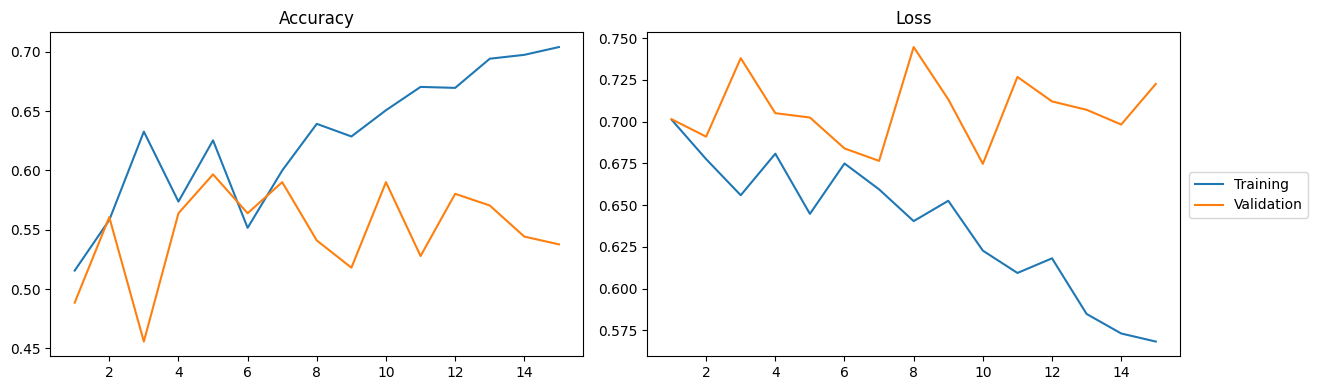

In [ ]:
plot_history(history)

# LSTM model

LSTMs don't have a fundamentally different architecture from RNNs, but they use a different function to compute the hidden state. The memory in LSTMs are called cells and you can think of them as black boxes that take as input the previous state $h_{t-1}$ and current input $x_t$. Internally these cells  decide what to keep in (and what to erase from) memory. They then combine the previous state, the current memory, and the input. It turns out that these types of units are very efficient at capturing long-term dependencies.

# Exercise: LSTM model

In [ ]:
def get_lstm_model(sequence_size, channel):
    model = tf.keras.Sequential([
        # TODO: add LSTM layer - https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
lstm_model = get_lstm_model(sequence_size = X_train.shape[1], channel = X_train.shape[2])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 dense_2 (Dense)             (None, 50)                3250      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 20965 (81.89 KB)
Trainable params: 20965 (81.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_model = compile_model(lstm_model)

In [ ]:
history = lstm_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=15,
    validation_split=0.2
)

Epoch 1/15
39/39 [==============================] - 4s 40ms/step - loss: 0.6922 - accuracy: 0.5262 - val_loss: 0.6897 - val_accuracy: 0.5574
Epoch 2/15
39/39 [==============================] - 1s 37ms/step - loss: 0.6841 - accuracy: 0.5590 - val_loss: 0.7035 - val_accuracy: 0.5836
Epoch 3/15
39/39 [==============================] - 2s 42ms/step - loss: 0.6472 - accuracy: 0.6238 - val_loss: 0.6293 - val_accuracy: 0.6492
Epoch 4/15
39/39 [==============================] - 2s 41ms/step - loss: 0.6260 - accuracy: 0.6418 - val_loss: 0.6271 - val_accuracy: 0.6754
Epoch 5/15
39/39 [==============================] - 1s 28ms/step - loss: 0.6260 - accuracy: 0.6336 - val_loss: 0.6419 - val_accuracy: 0.6393
Epoch 6/15
39/39 [==============================] - 1s 27ms/step - loss: 0.6161 - accuracy: 0.6459 - val_loss: 0.6487 - val_accuracy: 0.6525
Epoch 7/15
39/39 [==============================] - 1s 28ms/step - loss: 0.6231 - accuracy: 0.6328 - val_loss: 0.6195 - val_accuracy: 0.6623
Epoch 8/15
39

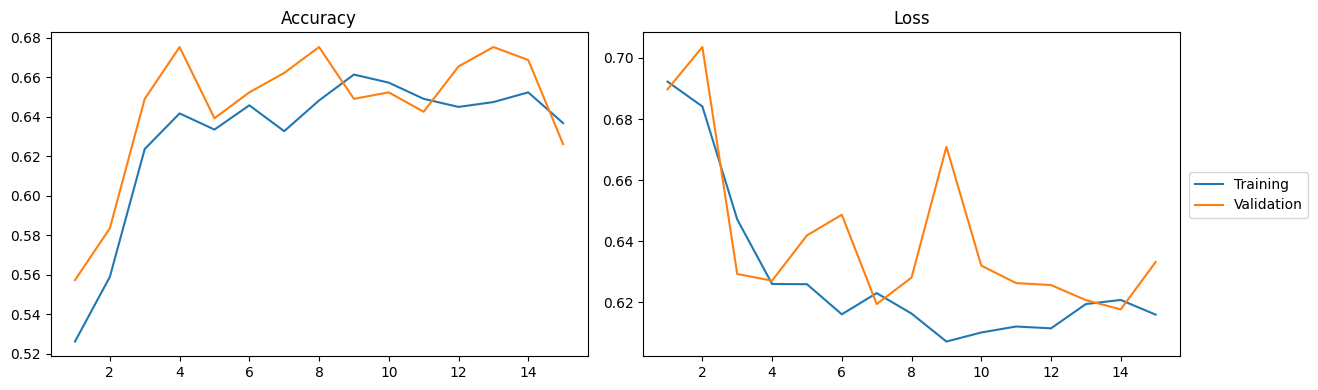

In [ ]:
plot_history(history)

# Bidirectional LSTM

Bidirectional-LSTM (Bi-LSTM) is a type of recurrent neural network (RNN) that processes sequential data in both forward and backward directions. It combines the power of LSTM with bidirectional processing, allowing the model to capture both past and future context of the input sequence. It consists of two LSTM layers: one processing the sequence in the forward direction and the other in the backward direction. Each layer maintains its own hidden states and memory cells.

In [ ]:
def get_bi_lstm_model(sequence_size, channel):
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(sequence_size, channel)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  return model

In [ ]:
bi_lstm_model = get_bi_lstm_model(sequence_size = X_train.shape[1], channel = X_train.shape[2])
bi_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128)               35328     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 50)                6450      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 41829 (163.39 KB)
Trainable params: 41829 (163.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
bi_lstm_model = compile_model(bi_lstm_model)

In [ ]:
history = bi_lstm_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=15,
    validation_split=0.2
)

Epoch 1/15
39/39 [==============================] - 7s 67ms/step - loss: 0.6711 - accuracy: 0.5934 - val_loss: 0.6483 - val_accuracy: 0.6525
Epoch 2/15
39/39 [==============================] - 2s 48ms/step - loss: 0.6315 - accuracy: 0.6434 - val_loss: 0.6164 - val_accuracy: 0.6754
Epoch 3/15
39/39 [==============================] - 3s 76ms/step - loss: 0.6030 - accuracy: 0.6680 - val_loss: 0.6079 - val_accuracy: 0.6656
Epoch 4/15
39/39 [==============================] - 2s 46ms/step - loss: 0.5865 - accuracy: 0.6697 - val_loss: 0.6194 - val_accuracy: 0.6852
Epoch 5/15
39/39 [==============================] - 2s 41ms/step - loss: 0.5912 - accuracy: 0.6754 - val_loss: 0.6108 - val_accuracy: 0.6590
Epoch 6/15
39/39 [==============================] - 2s 41ms/step - loss: 0.5838 - accuracy: 0.6787 - val_loss: 0.5970 - val_accuracy: 0.6885
Epoch 7/15
39/39 [==============================] - 2s 41ms/step - loss: 0.5704 - accuracy: 0.6820 - val_loss: 0.6101 - val_accuracy: 0.6754
Epoch 8/15
39

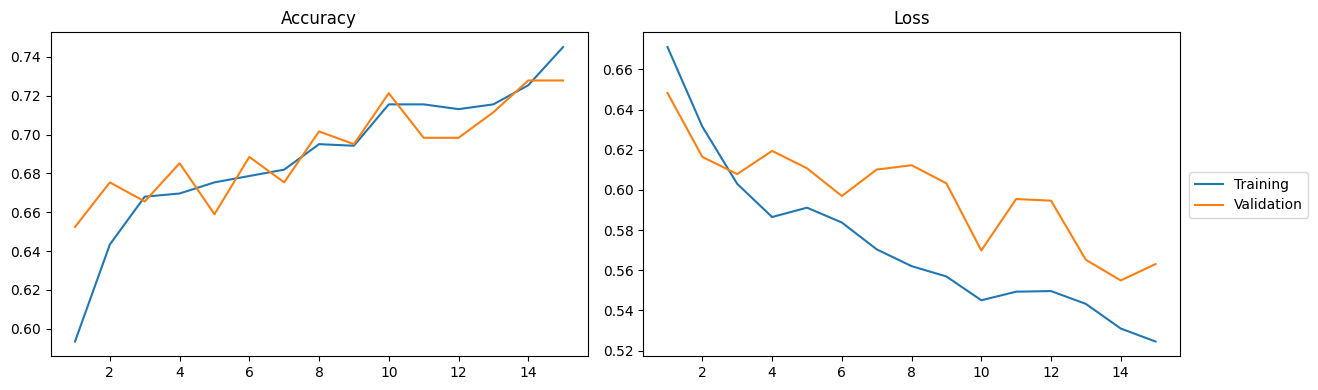

In [ ]:
plot_history(history)

# Evaluation

In [ ]:
def evaluate_model(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = [0 if prob < 0.5 else 1 for prob in y_pred]

    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
    auc_pr = auc(recall_curve, precision_curve)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        #'Precision': precision,
        #'Recall': recall,
        #'F1': f1,
        'AUCPR': auc_pr
    }

    return [accuracy, precision, recall, f1, auc_pr]

def summarize_models(models, X_test, y_test):
    summary = []
    for model_name, model in models.items():
        summary.append(evaluate_model(model, model_name, X_test, y_test))
    return pd.DataFrame(summary)

models = {
    'RNN': rnn_model,
    'LSTM': lstm_model,
    'BiLSTM': bi_lstm_model
}

summary = summarize_models(models, X_test, y_test)
print(summary)

    Model  Accuracy     AUCPR
0     RNN  0.554974  0.537810
1    LSTM  0.625654  0.590737
2  BiLSTM  0.680628  0.704324


# Exercise: Save and load models

When you train a model you are happy with, you might need to save it. Up to now, all of our models are only in memory and when we close Colab, they are gone.

Have a look at TensorFlow documentation [Save and load models](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) to see how to do it.